In [1]:
import os
import numpy as np
from time import time

# Keras fix
import tensorflow
from tensorflow.python.ops import control_flow_ops
tensorflow.python.control_flow_ops = control_flow_ops

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Input, merge, Dropout, Activation
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.utils.np_utils import to_categorical

from nl.utils import load_w2v_data, generate_train_data, shuffle_data, BatchGenerator

Using TensorFlow backend.
/home/m20163692/anaconda3/envs/tf/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
# Hyperparams - model
seq_len = 12
lstm_dim = 500
dense_dim = 1500
drop_out = 0.2

# Hyperparams - training
train_batch = 128000
train_iterations = 50
batch_size = 256

model_file = 'models/asimov_model.h5'
model_log = 'models/asimov_model.log'
model_log_np = 'models/asimov_model.npz'

w2v_vocab = 'w2v_embs/asimov/asimov_vocab.json'
w2v_embeddings = 'w2v_embs/asimov/asimov_embeddings.npz'

In [3]:
# Load data
word2idx, idx2word, embeddings = load_w2v_data(w2v_vocab, w2v_embeddings)

x, y = generate_train_data(word2idx, 'text_files/asimov', seq_len=seq_len,
                           mode='general_1', content='dir')

n_words = embeddings.shape[0]
input_dim = embeddings.shape[1]

print('\nNumber of words: %d\nEmbedding dimensions: %d' % (n_words, input_dim))

batch_generator = BatchGenerator(x, y, batch_size=train_batch)

del(x)
del(y)

Generating train data...
10.04s

Number of words: 47903
Embedding dimensions: 200


### Model

In [4]:
def branch_model(x, backwards=False):
    x = LSTM(lstm_dim, return_sequences=True, go_backwards=backwards)(x)
    x = BatchNormalization()(x)
    x = LSTM(lstm_dim, go_backwards=backwards)(x)
    return x

if os.path.exists(model_file):
    print('Loading model...')
    model = load_model(model_file)
else:
    print('Building model...')
    model_input = Input(shape=(seq_len, input_dim))
    data_input = TimeDistributed(Dense(lstm_dim), input_shape=(seq_len, input_dim))(model_input)
    data_input = BatchNormalization()(data_input)

    left_branch = branch_model(data_input)
    right_branch = branch_model(data_input, backwards=True)

    merged = merge([left_branch, right_branch], mode='concat')
    merged = BatchNormalization()(merged)
    merged = Dropout(drop_out)(merged)

    dense = Dense(dense_dim)(merged)
    dense = ELU()(dense)
    dense = Dropout(drop_out)(dense)

    dense = Dense(n_words, activation='softmax')(dense)

    model = Model(model_input, dense)
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
if os.path.exists(model_log_np):
    np_log = np.load(open(model_log_np, 'rb'))
    log_acc = list(np_log[0])
    log_loss = list(np_log[1])
else:
    log_acc = []
    log_loss = []

Loading model...


### Training

In [ ]:
def write_log(text, verbose=True):
    if verbose:
        print(text)
    text += '\n'
    with open(model_log, 'a') as f:
        f.write(text)

write_log('-'*40)
write_log('TRAINING BEGINS')
write_log('-'*40)

t0 = time()

for iteration, (x, y) in enumerate(batch_generator):
    it_t0 = time()
    if iteration == train_iterations: break
    
    batch_generator
    train_x = embeddings[x]
    train_y = to_categorical(y, n_words)
    hist = model.fit(train_x, train_y, batch_size=batch_size, nb_epoch=1)
    acc = hist.history['acc']
    loss = hist.history['loss']
    log_acc.append(acc[0])
    log_loss.append(loss[0])
    write_log('(Iteration %d) loss: %.4f - acc: %.4f (%.2fs)' %
              (iteration + 1, loss[0], acc[0], time() - it_t0), False)
    del(train_x)
    del(train_y)
    
    model.save(model_file)
    np_log = np.asarray([log_acc,log_loss])
    np.save(open(model_log_np, 'wb'), np_log)
        
write_log('Total training time: %.2fs' % (time() - t0))
write_log('-'*40)
write_log('TRAINING ENDS')
write_log('-'*40)

----------------------------------------
TRAINING BEGINS
----------------------------------------
Epoch 1/1
 10240/128000 [=>............................] - ETA: 445s - loss: 5.9955 - acc: 0.2612

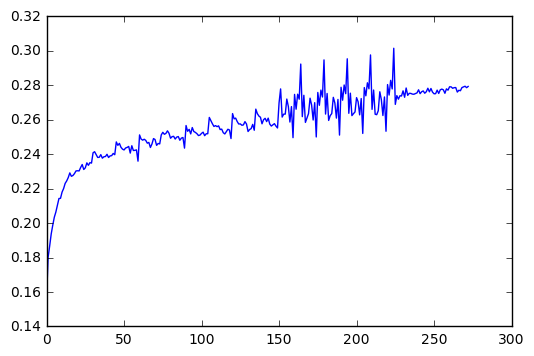

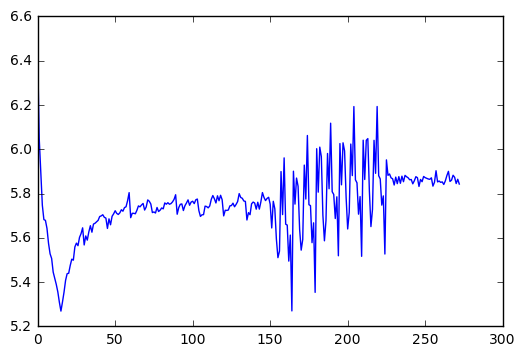

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(log_acc)
plt.show()

plt.plot(log_loss)
plt.show()

In [6]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

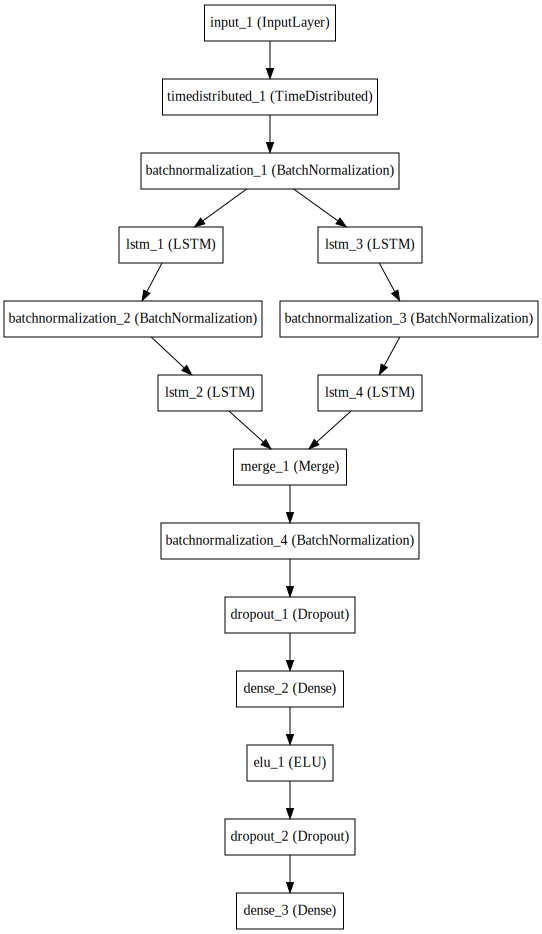

In [5]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))